# Tutorial Pengolahan Data Multidimensi menggunakan Xarray

Xarray menggunakan properti seperti dimensi, koordinat, dan atribut di atas array yang mirip dengan NumPy, yang membuat pengalaman pengguna menjadi lebih gampang, praktis, dan mengurangi kesalahan. Modul ini punya banyak fungsi yang bisa dipakai untuk berbagai keperluan, dari analisis data kompleks sampai visualisasi.
Xarray terinspirasi dari pandas, paket analisis data yang sering digunakan untuk data tabel yang punya label. Xarray cocok banget untuk digunakan dengan file netCDF, yang jadi dasar model datanya, dan bekerja sama dengan dask untuk mengolah data secara paralel.

In [1]:
#Install module/library "xarray", "cartopy", "cdsapi"
#Import module/library yang dibutuhkan
import xarray as xr
import pandas as pd
import numpy as np
import cdsapi

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter

## Download data via CDS API Copernicus

In [4]:
#Download netcdf dataset ERA5 via cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': [
            'reanalysis',
        ],
        'variable': [
            'specific_humidity', 'relative_humidity', 'u_component_of_wind', 'v_component_of_wind',
        ],
        'pressure_level': [
            '800', '825', '850',
            '900', '925', '950',
            '975', '1000',
        ],
        'year': '2024',
        'month': '03',
        'day': ['18','19'],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            12, 125, -12,
            155,
        ],
        'format': 'netcdf',
    },
    'era5_papua_18mar24.nc')

Exception: Missing/incomplete configuration file: C:\Users\Jakar/.cdsapirc

## Membuka dataset NetCDF

### Dimensions, Coordinates, Data variables, dan Attributes. 
Dimensions adalah kerangka koordinat (Coordinates) data yang mengacu pada konvensi metadata NetCDF. 
Data variables mencantumkan semua variabel yang bukan koordinat. 
Indexes adalah indeks koordinat. Attributes adalah metadata dataset.

Xarray menyediakan dua struktur data: DataArray dan Dataset. Kelas DataArray menambahkan nama dimensi, koordinat, dan atribut ke array multi-dimensi, sementara Dataset menggabungkan beberapa array.

![XarrayStructure](https://i.postimg.cc/02VqJV2R/Screenshot-2024-05-26-at-9-48-24-am.png)

In [4]:
#Buka data yang sudah diunduh menggunakan module xarray
datanc = xr.open_dataset('era5_papua_18mar24.nc')
datanc

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Jakar\\AppData\\Local\\Programs\\Microsoft VS Code\\era5_papua_18mar24.nc'

### Konversi waktu

In [61]:
#Konversi dari UTC ke Local Time (WIT)
times_pd = pd.to_datetime(datanc['time'].values)
times_pd_utc = times_pd.tz_localize('UTC')  # Localize to UTC first
times_wit = times_pd_utc.tz_convert('Asia/Jayapura')  # Convert to WIT, Asia/Jayapura is UTC+9

times_naive = times_wit.tz_localize(None)
times_naive_np = np.array(times_naive, dtype='datetime64[ns]')
datanc['time_in_WIT'] = ('time', times_naive_np)

## Mengakses data / seleksi variabel 

In [4]:
#Definisikan variable untuk menyimpan variable q (specific humidity)
q_var = datanc['q']
print('q_array:', q_var)

q_array: <xarray.DataArray 'q' (time: 48, level: 8, latitude: 97, longitude: 121)> Size: 18MB
[4507008 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 484B 125.0 125.2 125.5 ... 154.5 154.8 155.0
  * latitude   (latitude) float32 388B 12.0 11.75 11.5 ... -11.5 -11.75 -12.0
  * level      (level) int32 32B 800 825 850 900 925 950 975 1000
  * time       (time) datetime64[ns] 384B 2024-03-18 ... 2024-03-19T23:00:00
Attributes:
    units:          kg kg**-1
    long_name:      Specific humidity
    standard_name:  specific_humidity


In [5]:
# Menyeleksi data pada indeks waktu kedua (indeks dimulai dari 0)
q_time0 = q_var.isel(time=1)  # 'isel' digunakan untuk seleksi berdasarkan indeks integer

# Menyeleksi data pada tanggal dan jam tertentu secara eksak
q_time1 = q_var.sel(time='2024-03-19T00:00:00')  # 'sel' digunakan untuk seleksi berdasarkan label

# Menyeleksi data pada tanggal dan jam yang paling dekat dengan waktu yang ditentukan
q_timeaw = q_var.sel(time='2024-03-19T01:23:23', method='nearest')  # 'nearest' mencari waktu terdekat

# Mencetak hasil seleksi ke layar
print('q_time0:', q_time0)
print('q_time1:', q_time1)
print('q_timeaw:', q_timeaw)

q_time0: <xarray.DataArray 'q' (level: 8, latitude: 97, longitude: 121)> Size: 376kB
[93896 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 484B 125.0 125.2 125.5 ... 154.5 154.8 155.0
  * latitude   (latitude) float32 388B 12.0 11.75 11.5 ... -11.5 -11.75 -12.0
  * level      (level) int32 32B 800 825 850 900 925 950 975 1000
    time       datetime64[ns] 8B 2024-03-18T01:00:00
Attributes:
    units:          kg kg**-1
    long_name:      Specific humidity
    standard_name:  specific_humidity
q_time1: <xarray.DataArray 'q' (level: 8, latitude: 97, longitude: 121)> Size: 376kB
[93896 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 484B 125.0 125.2 125.5 ... 154.5 154.8 155.0
  * latitude   (latitude) float32 388B 12.0 11.75 11.5 ... -11.5 -11.75 -12.0
  * level      (level) int32 32B 800 825 850 900 925 950 975 1000
    time       datetime64[ns] 8B 2024-03-19
Attributes:
    units:          kg kg**-1
    long_name:      Specific hu

In [6]:
# Mengiris data dari awal sampai elemen ke-12 (indeks 0 sampai 11)
q_time3 = q_var[:12]  # Pemotongan menggunakan slicing Python standar

# Mengiris data dalam rentang waktu tertentu, dari 18 Maret 2024 jam 00:00 hingga 19 Maret 2024 jam 11:00
q_time4 = q_var.sel(time=slice('2024-03-18T00:00:00', '2024-03-19T11:00:00'))  # 'sel' dan 'slice' digunakan untuk seleksi berdasarkan rentang waktu

print('q_time3:', q_time3)
print('q_time4:', q_time4)

q_time3: <xarray.DataArray 'q' (time: 12, level: 8, latitude: 97, longitude: 121)> Size: 5MB
[1126752 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 484B 125.0 125.2 125.5 ... 154.5 154.8 155.0
  * latitude   (latitude) float32 388B 12.0 11.75 11.5 ... -11.5 -11.75 -12.0
  * level      (level) int32 32B 800 825 850 900 925 950 975 1000
  * time       (time) datetime64[ns] 96B 2024-03-18 ... 2024-03-18T11:00:00
Attributes:
    units:          kg kg**-1
    long_name:      Specific humidity
    standard_name:  specific_humidity
q_time4: <xarray.DataArray 'q' (time: 36, level: 8, latitude: 97, longitude: 121)> Size: 14MB
[3380256 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 484B 125.0 125.2 125.5 ... 154.5 154.8 155.0
  * latitude   (latitude) float32 388B 12.0 11.75 11.5 ... -11.5 -11.75 -12.0
  * level      (level) int32 32B 800 825 850 900 925 950 975 1000
  * time       (time) datetime64[ns] 288B 2024-03-18 ... 2024-03-19T11:00

In [9]:
# Mengiris data menggunakan interval
q_6h = q_var[:24:6]
q_12h = q_var[:48:12]

q_6h

<xarray.DataArray 'q' (time: 4, level: 8, latitude: 97, longitude: 121)> Size: 2MB
[375584 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 484B 125.0 125.2 125.5 ... 154.5 154.8 155.0
  * latitude   (latitude) float32 388B 12.0 11.75 11.5 ... -11.5 -11.75 -12.0
  * level      (level) int32 32B 800 825 850 900 925 950 975 1000
  * time       (time) datetime64[ns] 32B 2024-03-18 ... 2024-03-18T18:00:00
Attributes:
    units:          kg kg**-1
    long_name:      Specific humidity
    standard_name:  specific_humidity

In [10]:
# Seleksi data pada waktu spesifik dan level tertentu
# Dalam contoh ini, memilih data pada tanggal 19 Maret 2024 pukul 00:00 dengan level 850
q_850 = q_var.sel(time='2024-03-19T00:00:00', level=850)  # 'sel' digunakan untuk seleksi berdasarkan label

### Latihan 1

Tulislah kode untuk menyeleksi angin u pada level 850 hPa pada rentang waktu 10Z hingga 15Z 19 Maret 2024

## Visualisasi sederhana untuk mengecek dataset
Xarray mempunyai metode built-in plot() untuk melakukan visualisasi data secara sederhana. 

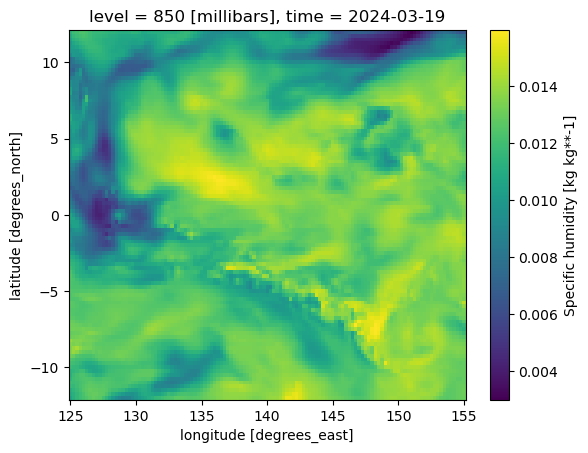

In [11]:
# plot spasial 2 dimensi
q_850.plot()

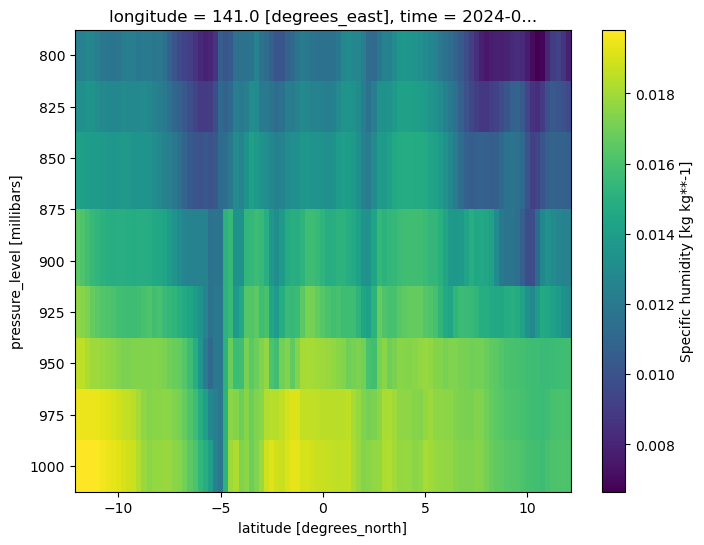

In [12]:
# plot iris sepanjang latitude
q_lats = q_var.sel(time='2024-03-19T00:00:00', longitude=141)
q_lats.plot(size=6, yincrease=False )

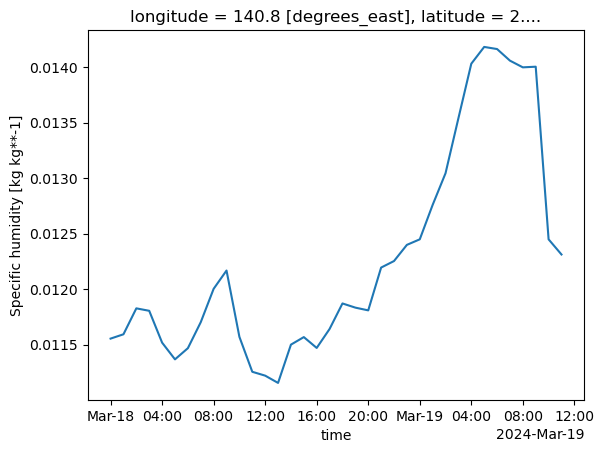

In [13]:
#Seleksi variable dari satu grid point dan plot time series
q_ts = q_time4.sel(longitude=140.8, latitude=2.3, level=850, method='nearest')
q_ts.plot()

## Operasi matematika pada dataset
Xarray dibangun menggunakan numpy dan pandas, sehingga dapat melakukan metode operasi matematika sebagaimana dilakukan pada numpy array dan Pandas dataframe.

In [16]:
# Mencari nilai maksimum, minimum, dan rata-rata
print('max:', q_var.values.max())
print('min:', q_var.values.min())
print('mean:', q_var.values.mean())

max: 0.022466052
min: 0.0011943737
mean: 0.014334151


In [17]:
# Penjumlahan dan rata-rata
q_alllevel = q_var.sum(dim='level')
q_alllevel_mean = q_var.sum(dim='level').mean(dim='time')

# Perhitungan anomali
q_anom = q_alllevel - q_alllevel_mean
q_anom.isel(time=0).plot()

<xarray.DataArray 'q' (time: 48, latitude: 97, longitude: 121)> Size: 2MB
array([[[-0.0006278 , -0.00059897, -0.00181036, ...,  0.00453612,
          0.00345565,  0.00384594],
        [-0.00279332, -0.00261316, -0.0019637 , ...,  0.00113825,
          0.00130838,  0.00214685],
        [-0.00506641, -0.00259959, -0.00194117, ..., -0.00110116,
         -0.00058363,  0.00112461],
        ...,
        [ 0.00650713,  0.00467695,  0.0035089 , ..., -0.01626594,
         -0.01840719, -0.01836273],
        [ 0.00517397,  0.00320556,  0.0015837 , ..., -0.01941802,
         -0.01969002, -0.01892173],
        [ 0.00182096,  0.00033171, -0.0012086 , ..., -0.01813829,
         -0.01798559, -0.01641291]],

       [[-0.00056387, -0.00104693, -0.00199635, ...,  0.00462928,
          0.00390945,  0.00423707],
        [-0.00180007, -0.00203539, -0.00160276, ...,  0.00181828,
          0.00215785,  0.00284214],
        [-0.00325321, -0.00235485, -0.00200153, ...,  0.00040593,
          0.00093839,  0.0023

### Latihan 2

Tulislah kode untuk mencari nilai rata-rata spatial angin u level 850 yang sudah diseleksi pada Latihan 1 dan coba plot

### Operasi matematik lanjutan
Menghitung magnitudo angin dan vertically integrated moisture convergence

In [18]:
# Magnitudo angin
u975 = datanc['u'].sel(level=975)
v975 = datanc['v'].sel(level=975)
mag_wind975 = np.sqrt(u975**2 + v975**2) # menghitung sqrt power

# Menghitung 90th percentile magnitudo angin
mag_wind975_90per = mag_wind975.quantile(0.9, dim='time')
print('90 percentile magnitude angin 975-hPa:', mag_wind975_90per)

90 percentile magnitude angin 975-hPa: <xarray.DataArray (latitude: 97, longitude: 121)> Size: 94kB
array([[ 5.78449159,  5.36404338,  6.2877182 , ...,  6.90314322,
         6.92219834,  6.94302158],
       [ 5.42074418,  5.46857677,  6.23887243, ...,  6.96273828,
         7.01352849,  7.00378442],
       [ 5.03837752,  5.39575763,  6.29192128, ...,  6.95976024,
         6.96196842,  6.92059035],
       ...,
       [ 9.92633934, 10.10977163, 10.31850386, ...,  8.20532637,
         8.51336641,  8.71295805],
       [ 9.79382172, 10.00070286, 10.26084223, ...,  8.63764009,
         8.81939516,  8.94657421],
       [ 9.70654421,  9.93019247, 10.13420258, ...,  8.86674967,
         9.03685408,  9.05182962]])
Coordinates:
  * longitude  (longitude) float32 484B 125.0 125.2 125.5 ... 154.5 154.8 155.0
  * latitude   (latitude) float32 388B 12.0 11.75 11.5 ... -11.5 -11.75 -12.0
    quantile   float64 8B 0.9


### Menghitung vertically integrated moisture fluc convergence (VIMFC)

![VIMFC Eq](https://i.postimg.cc/GmWJHX6y/Capture.png)

In [19]:
def calc_vimfc (u, v, q, lat, lon, lev):
    # Komponen angin dan specific humidity
    uq = u*q
    vq = v*q
    
    # Centre finite Difference
    d_uq = uq.differentiate(lon)
    d_vq = vq.differentiate(lat)
    
    # X + Y
    conv = d_uq + d_vq
    
    # Integralkan semua level
    moistconv = conv.integrate(lev)
    
    vimfc_val = moistconv/-9.8
    return (vimfc_val)

In [20]:
# Definisikan variabel yang akan digunakan
u = datanc['u']
v = datanc['v']
q = datanc['q']
lev = datanc['level']

# Panggil fungsi calc_vimfc
vimfc = calc_vimfc(u, v, q, 'latitude','longitude','level')

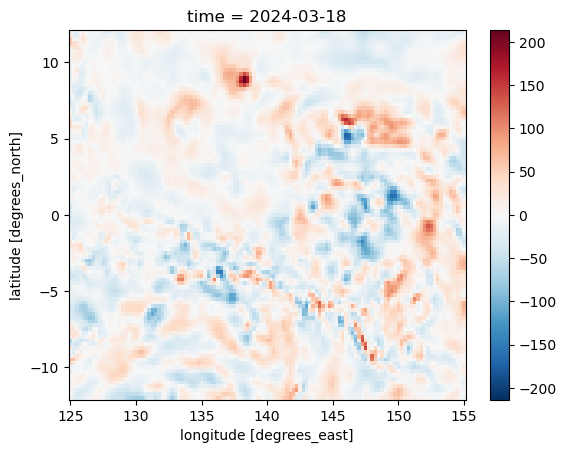

In [21]:
# Seleksi vimfc pada waktu tertentu dan plot
vimfc_sel = vimfc.sel(time='2024-03-18T00:00:00')
vimfc_sel.plot()

## Pensampelan ulang (resample), pengelompokan data (grouping), dan coarsening

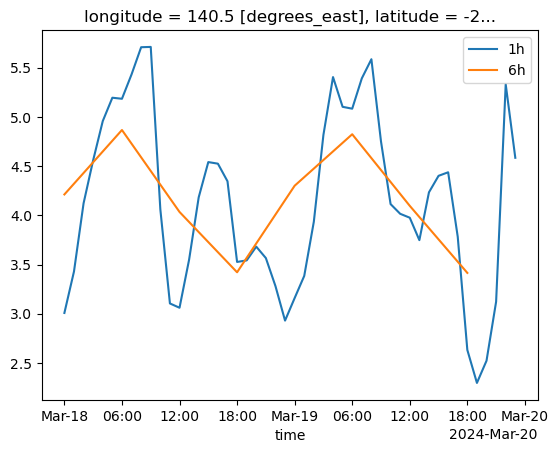

In [22]:
# Pilih data kecepatan angin terdekat dengan longitude 140.6 dan latitude -2.5
wind_jay = mag_wind975.sel(longitude=140.6, latitude=-2.5, method='nearest')

# Lakukan resampling data kecepatan angin ke interval 6 jam dan hitung rata-ratanya
wind_jay_6h = wind_jay.resample(time="6h").mean()  # 'resample' untuk mengubah interval waktu, 'mean' untuk rata-rata

# Plot data kecepatan angin asli dengan label '1h'
wind_jay.plot(label='1h')  # 'plot' fungsi dari xarray untuk visualisasi data

# Plot data kecepatan angin yang sudah di-resample dengan label '6h'
wind_jay_6h.plot(label='6h')  # Data yang lebih rata dengan interval 6 jam

plt.legend()  
plt.show() 

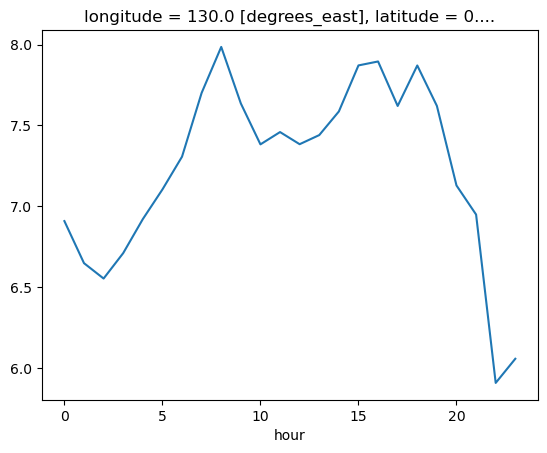

In [25]:
#Grouping
grouped = mag_wind975.groupby('time.hour').max()
grouped_sel = grouped.sel(longitude=130, latitude=0)
grouped_sel.plot()

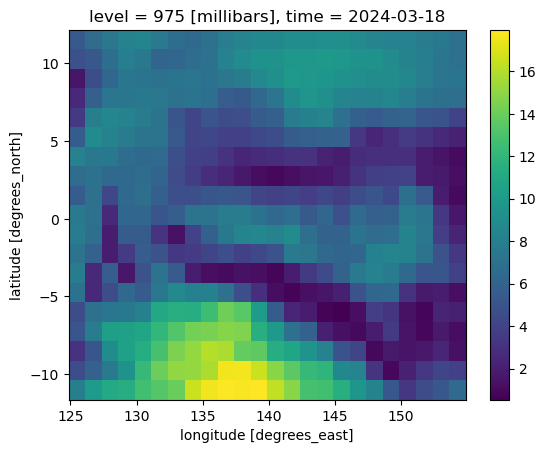

In [36]:
#Coarsening
sel_wind = mag_wind975.sel(time='2024-03-18T00:00:00')
coarse = sel_wind.coarsen(latitude=5, longitude=5, boundary="trim")
mean_coarse = coarse.mean()
mean_coarse.plot()

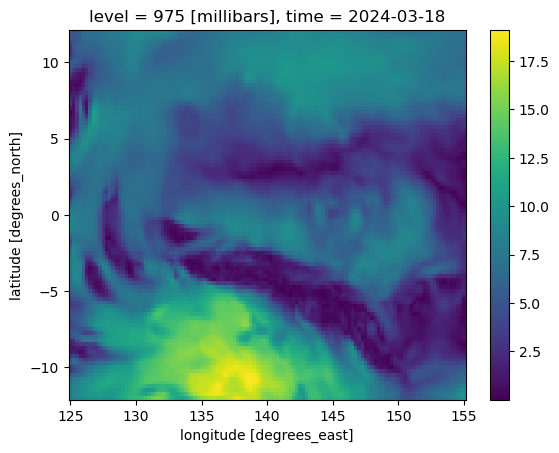

In [37]:
sel_wind.plot()

# Visualisasi dataset menggunakan Matplotlib dan Cartopy

In [39]:
lats = datanc['latitude']
lons = datanc['longitude']
lons, lats = np.meshgrid(lons, lats)

### Peta imshow

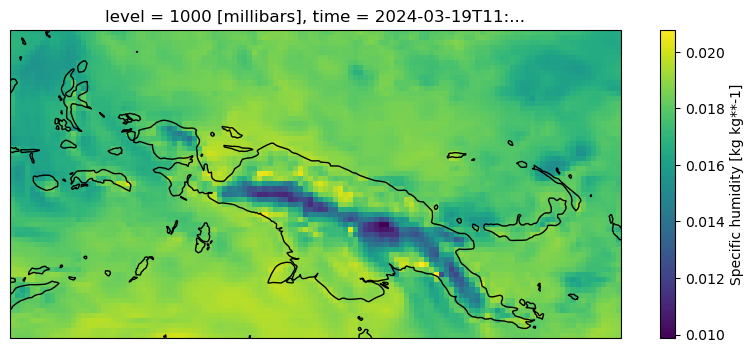

In [41]:
# Membuat figure dengan ukuran tertentu
plt.figure(figsize=(10., 4.))

# Seleksi data dari variabel 'q_var' untuk waktu tertentu dan irisan latitude serta longitude
# dan tingkat level tertentu (1000 hPa)
q_plot = q_var.sel(time='2024-03-19T11:00:00', latitude=slice(4, -11), longitude=slice(125, 155), level=1000)

# Membuat axes dengan proyeksi PlateCarree, yang umum digunakan untuk data geografis
ax = plt.axes(projection=ccrs.PlateCarree())

# Menambahkan garis pantai ke plot
ax.coastlines()

# Melakukan plotting data yang telah diseleksi
q_plot.plot()
plt.show()

### Peta Contour fill

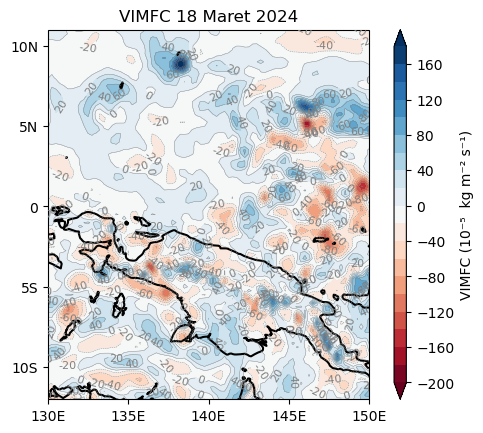

In [60]:
# Menetapkan proyeksi data yang akan digunakan untuk plotting
datacrs = ccrs.PlateCarree()

# Membuat axes dengan proyeksi yang telah ditetapkan
ax = plt.axes(projection=datacrs)

# Mengatur batas tampilan peta dengan koordinat tertentu
ax.set_extent([130, 150, 11, -12], crs=datacrs)

# Mengatur label pada sumbu x (garis bujur) dengan proyeksi yang sesuai
ax.set_xticks([130, 135, 140, 145, 150], crs=datacrs)

# Mengatur label pada sumbu y (garis lintang) dengan proyeksi yang sesuai
ax.set_yticks([10, 5, 0, -5, -10], crs=datacrs)

# Menambahkan garis pantai dengan detail tinggi dan lebar garis 1.5
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1.5)

# Mengatur formatter untuk garis bujur sehingga tidak ada simbol derajat dan format tanpa desimal
lon_formatter = LongitudeFormatter(number_format='.0f',
                                       degree_symbol='',
                                       dateline_direction_label=True)

# Mengatur formatter untuk garis lintang dengan format tanpa desimal dan tanpa simbol derajat
lat_formatter = LatitudeFormatter(number_format='.0f',
                                      degree_symbol='')

# Menerapkan formatter yang telah disetel ke sumbu x dan y
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Mendefinisikan range untuk colorbar berdasarkan data
cbar = list(range(-200, 200, 20))

# Melakukan contour fill plot pada data dengan nilai longitude, latitude, dan data yang dipilih
plot_v = ax.contourf(lons, lats, vimfc_sel, cbar, cmap=plt.cm.RdBu, extend='both', transform=datacrs)

# Menambahkan garis kontur di atas plot isi kontur untuk menonjolkan tingkat tertentu
contour_lines = ax.contour(lons, lats, vimfc_sel, cbar, colors='grey', vmin=0, linewidths=0.3, transform=datacrs)
# Menambahkan label ke garis kontur
plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%.0f')

# Menambahkan colorbar vertikal, mengatur aspek, dan labelnya
cb = plt.colorbar(plot_v, orientation='vertical', aspect=30)
cb.set_label('VIMFC (10⁻⁵  kg m⁻² s⁻¹)')

# Mengatur judul plot
plt.title('VIMFC 18 Maret 2024')
plt.show()

### Peta magnitudo angin dan vektor

In [45]:
u975_0 = u975.isel(time=0).values
v975_0 = v975.isel(time=0).values

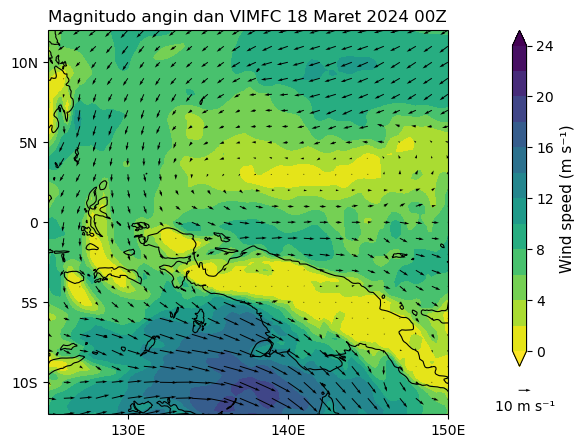

In [46]:
#tentukan batas wilayah yg mau diplot
boundary = [125, 150, 12, -12] #(xmin, xmax, ymax, ymin)
lons_tick = [130, 140, 150] # longitude yg mau dikasih tickmark
lats_tick = [10, 5, 0, -5, -10] # latitude yg mau dikasih tickmark

#formatter untuk atur style penulisan koordinat
lon_formatter = LongitudeFormatter(number_format='.0f', degree_symbol='', dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f', degree_symbol='')

#mulai bikin intruksi gambar
ax = plt.subplot(111, projection=datacrs)
#set formatting
ax.set_extent(boundary, datacrs)
ax.set_xticks(lons_tick, crs=datacrs)
ax.set_yticks(lats_tick, crs=datacrs)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
#add garis pantai
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.8, edgecolor='black', zorder=10)

#pewarnaan shading
cmag = list(np.arange(0, 25, 2))
wind_mag_plot = ax.contourf(lons, lats, mag_wind975.isel(time=0), cmag, cmap=plt.cm.viridis_r, extend='both', transform=datacrs, zorder=1)

#add vektor vimfc
skip=(slice(None,None,4),slice(None,None,4))
wind_vec_plot = ax.quiver(lons[skip], lats[skip], u975_0[skip], v975_0[skip], pivot='tail', transform=datacrs, zorder=5)

#tambahkan judul
ax.set_title('Magnitudo angin dan VIMFC 18 Maret 2024 00Z', loc='left')

#tambahkan colorbar dan legend vektor
plt.subplots_adjust(bottom=0.1, right=1.05, top=0.9, wspace=0.025, hspace=0.14)
cax = plt.axes([1.001, 0.2, 0.022, 0.7])
ca = plt.colorbar(wind_mag_plot, cax=cax, orientation='vertical', aspect=50)
ca.set_label('Wind speed (m s⁻¹)', fontsize=11)
ax.quiverkey(wind_vec_plot, 1.02, 0.15, 10, '10 m s⁻¹', labelpos='S', zorder=24,
                   coordinates='figure')


#plt.tight_layout()
#save gambar
#plt.savefig('Figure_VIMFC.pdf', dpi=500, bbox_inches='tight')
plt.show()

### Multipanel plot

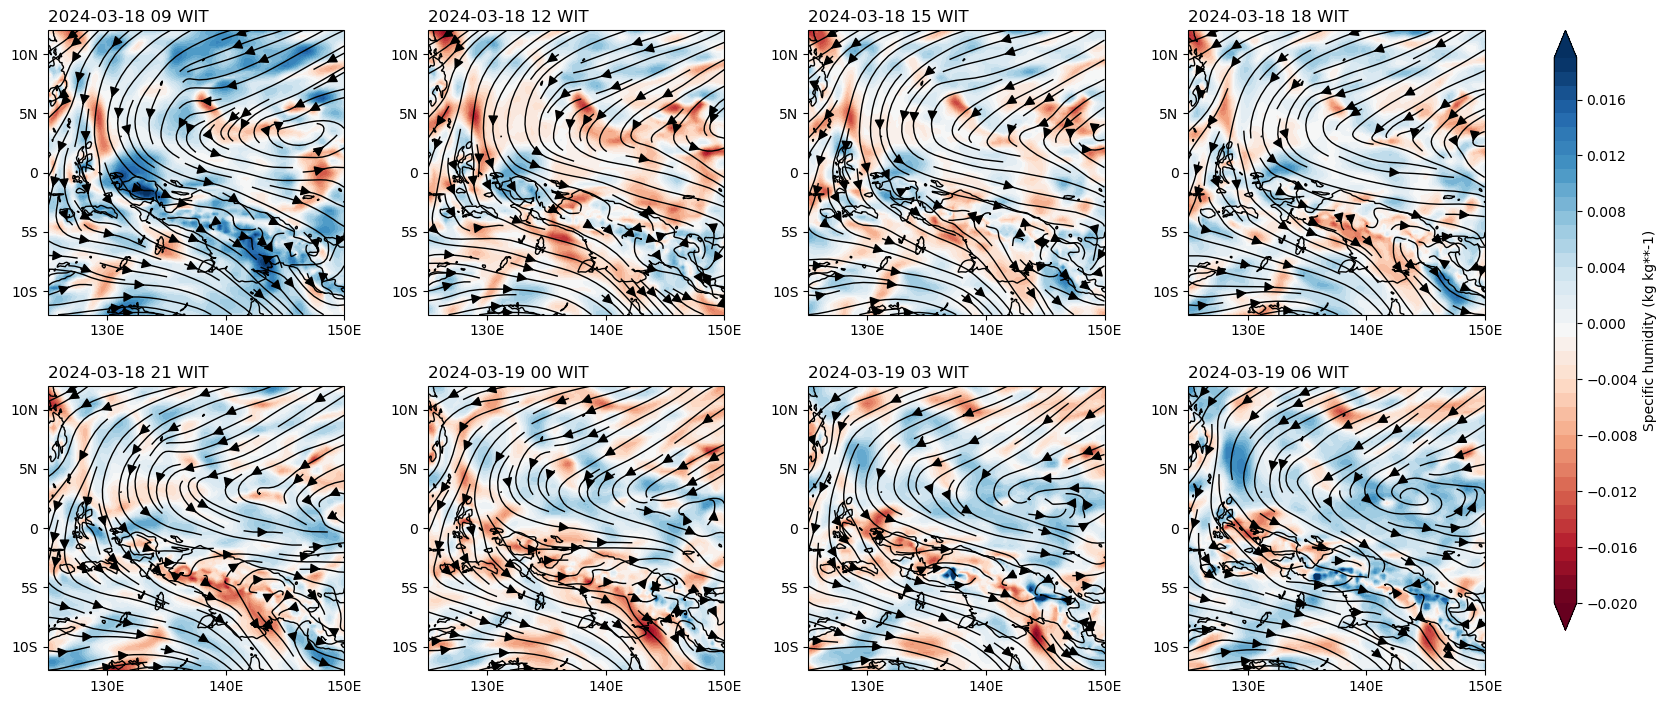

In [62]:
# Ambil waktu dari data dan format jadi YYYY-MM-DD HH format, ambil setiap 3 jam dari 48 jam pertama
time_tick = datanc['time_in_WIT'][0:48:3].values
formatted_time_tick = np.array([pd.Timestamp(t).strftime('%Y-%m-%d %H') for t in time_tick])

# Buat subplot dengan 2 baris dan 4 kolom, semua subplot share sumbu x dan y, dan gunakan proyeksi peta yang sama
fig, axs = plt.subplots(2, 4, sharey=True, sharex=True, figsize=(16., 8.), subplot_kw={'projection': datacrs})
axs = axs.ravel()  # Ubah array 2D dari axs jadi 1D supaya lebih gampang di-loop

# Loop untuk setiap axes untuk plotting
for i, ax in enumerate(axs):
    timetick = formatted_time_tick[i]  # Ambil waktu yang sudah diformat untuk tiap subplot
    ax.set_extent(boundary, crs=datacrs)  # Atur batas tampilan peta
    ax.set_xticks(lons_tick, crs=datacrs)  # Atur tik di sumbu x
    ax.set_yticks(lats_tick, crs=datacrs)  # Atur tik di sumbu y

    # Formatter untuk sumbu x dan y, hilangkan simbol derajat
    ax.xaxis.set_major_formatter(LongitudeFormatter(number_format='.0f', degree_symbol='', dateline_direction_label=True))
    ax.yaxis.set_major_formatter(LatitudeFormatter(number_format='.0f', degree_symbol=''))

    ax.coastlines()  # Tambahkan garis pantai ke peta

    # Plot data kelembapan spesifik menggunakan contour fill
    colorvim_levels = np.arange(-0.02, 0.02, 0.001)
    contf = ax.contourf(lons, lats, q_anom.sel(time=timetick), levels=colorvim_levels, cmap=plt.cm.RdBu, extend='both', transform=datacrs, zorder=0)

    # Tambahkan streamplot untuk menunjukkan arah dan kecepatan angin
    ax.streamplot(lons, lats, u975.sel(time=timetick), v975.sel(time=timetick), color='k', linewidth=1., arrowsize=1.5, transform=datacrs) 

    # Set judul subplot berdasarkan waktu yang ditampilkan
    ax.set_title(f'{timetick} WIT', weight='normal', loc='left')

# Atur layout subplot dan tambahkan colorbar di samping kanan
fig.subplots_adjust(bottom=0.1, right=1.05, top=0.9, wspace=0.12, hspace=0.25)
cax = fig.add_axes([1.08, 0.15, 0.014, 0.75])
cb = plt.colorbar(contf, cax=cax, orientation='vertical', aspect=50)
cb.set_label('Specific humidity (kg kg**-1)')  # Label untuk colorbar

# Tampilkan plot
plt.show()

### Latihan 3

Buatlah multipanel 3 plot menggunakan contourf untuk magnitudo angin level 850, bebas pilih waktu mana saja

# Membuka multi dataset 

## Download data menggunakan module 'requests' dari server gsfc.nasa.gov

In [71]:
import requests
import os

# Fungsi untuk mendownload file 
def download_file(url, save_path): 
    local_filename = url.split('/')[-1]
    full_path = os.path.join(save_path, local_filename)
    
    with requests.get(url, stream=True) as r:
        r.raise_for_status()  
        with open(full_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print(f'Data saved to {full_path}')

Data saved to /Users/ridhoain/Documents/Meteorology Res/python4atmosphere/xarray/gpm/g4.subsetted.GPM_3IMERGM_06_precipitation.20100101.130E_8S_140E_0N.nc
Data saved to /Users/ridhoain/Documents/Meteorology Res/python4atmosphere/xarray/gpm/g4.subsetted.GPM_3IMERGM_06_precipitation.20100201.130E_8S_140E_0N.nc
Data saved to /Users/ridhoain/Documents/Meteorology Res/python4atmosphere/xarray/gpm/g4.subsetted.GPM_3IMERGM_06_precipitation.20100301.130E_8S_140E_0N.nc
Data saved to /Users/ridhoain/Documents/Meteorology Res/python4atmosphere/xarray/gpm/g4.subsetted.GPM_3IMERGM_06_precipitation.20100401.130E_8S_140E_0N.nc
Data saved to /Users/ridhoain/Documents/Meteorology Res/python4atmosphere/xarray/gpm/g4.subsetted.GPM_3IMERGM_06_precipitation.20100501.130E_8S_140E_0N.nc
Data saved to /Users/ridhoain/Documents/Meteorology Res/python4atmosphere/xarray/gpm/g4.subsetted.GPM_3IMERGM_06_precipitation.20100601.130E_8S_140E_0N.nc
Data saved to /Users/ridhoain/Documents/Meteorology Res/python4atmosph

In [ ]:
# Txt file berisi URL file yang mau didownload
filedata = 'prov.postprocess+sMpAn+dGPM_3IMERGM_06_precipitation+zNA+t20100101000000_20210531235959+b130.0000E8.0000S140.0000E0.0000N.txt'

# Path folder untuk menyimpan data yang telah didownload GANTI DENGAN PATH COMPUTER ANDA
new_folder_path = '/Users/ridhoain/Documents/Meteorology Res/python4atmosphere/xarray/gpm'

# Memastikan folder sudah ada
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)

# Membaca URL di setiap baris txt, dan memanggil fungsi download
with open(filedata, 'r') as file:
    for url in file:
        url = url.strip() 
        if url: 
            download_file(url, new_folder_path)

## Buka multifile dataset yang terletak pada satu folder

In [63]:
# Membuka banyak data dan membukanya menjadi satu dataset 
gpm_data = xr.open_mfdataset('gpm/*.nc')
gpm_data

<xarray.Dataset> Size: 5MB
Dimensions:                       (time: 137, lat: 80, lon: 100, latv: 2,
                                   lonv: 2, nv: 2)
Coordinates:
  * lat                           (lat) float32 320B -7.95 -7.85 ... -0.15 -0.05
  * lon                           (lon) float32 400B 130.1 130.1 ... 139.9 139.9
  * time                          (time) object 1kB 2010-01-01 00:00:00 ... 2...
Dimensions without coordinates: latv, lonv, nv
Data variables:
    GPM_3IMERGM_06_precipitation  (time, lat, lon) float32 4MB dask.array<chunksize=(1, 80, 100), meta=np.ndarray>
    datamonth                     (time) int32 548B dask.array<chunksize=(1,), meta=np.ndarray>
    lat_bnds                      (time, lat, latv) float64 175kB dask.array<chunksize=(1, 80, 2), meta=np.ndarray>
    lon_bnds                      (time, lon, lonv) float64 219kB dask.array<chunksize=(1, 100, 2), meta=np.ndarray>
    time_bnds                     (time, nv) object 2kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    nco_openmp_thread_number:  1
    Conventions:               CF-1.4
    start_time:                2010-01-01T00:00:00Z
    end_time:                  2010-02-01T00:00:00Z
    temporal_resolution:       monthly
    NCO:                       netCDF Operators version 5.0.6 (Homepage = htt...
    history:                   Sat May 25 18:48:14 2024: ncap2 -O -S /var/gio...
    title:                     Merged satellite-gauge precipitation estimate ...
    plot_hint_title:           Merged satellite-gauge precipitation estimate ...
    plot_hint_subtitle:         
    plot_hint_caption:         - Selected date range was 2010-Jan - 2021-May....

In [64]:
# Menkonversi format data 'time' dari object menjadi datetime64
formatted_dates = [str(date) for date in gpm_data.time.values]
time_as_timestamps = pd.to_datetime(formatted_dates)
gpm_data['time'] = ('time', time_as_timestamps)
gpm_data

<xarray.Dataset> Size: 5MB
Dimensions:                       (time: 137, lat: 80, lon: 100, latv: 2,
                                   lonv: 2, nv: 2)
Coordinates:
  * lat                           (lat) float32 320B -7.95 -7.85 ... -0.15 -0.05
  * lon                           (lon) float32 400B 130.1 130.1 ... 139.9 139.9
  * time                          (time) datetime64[ns] 1kB 2010-01-01 ... 20...
Dimensions without coordinates: latv, lonv, nv
Data variables:
    GPM_3IMERGM_06_precipitation  (time, lat, lon) float32 4MB dask.array<chunksize=(1, 80, 100), meta=np.ndarray>
    datamonth                     (time) int32 548B dask.array<chunksize=(1,), meta=np.ndarray>
    lat_bnds                      (time, lat, latv) float64 175kB dask.array<chunksize=(1, 80, 2), meta=np.ndarray>
    lon_bnds                      (time, lon, lonv) float64 219kB dask.array<chunksize=(1, 100, 2), meta=np.ndarray>
    time_bnds                     (time, nv) object 2kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    nco_openmp_thread_number:  1
    Conventions:               CF-1.4
    start_time:                2010-01-01T00:00:00Z
    end_time:                  2010-02-01T00:00:00Z
    temporal_resolution:       monthly
    NCO:                       netCDF Operators version 5.0.6 (Homepage = htt...
    history:                   Sat May 25 18:48:14 2024: ncap2 -O -S /var/gio...
    title:                     Merged satellite-gauge precipitation estimate ...
    plot_hint_title:           Merged satellite-gauge precipitation estimate ...
    plot_hint_subtitle:         
    plot_hint_caption:         - Selected date range was 2010-Jan - 2021-May....

## Grouping (lagi)

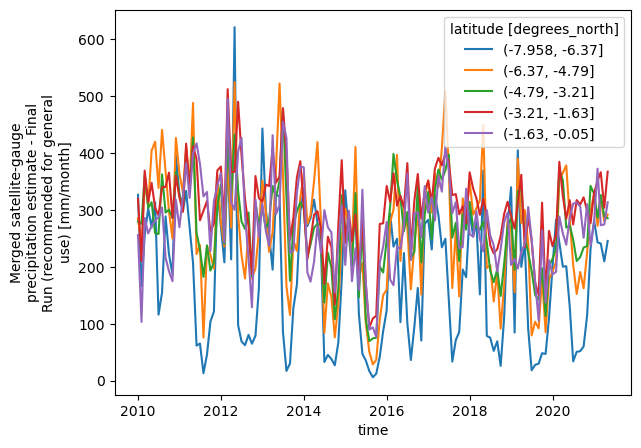

In [67]:
# Muat data hujan dari dataset GPM
hujan = gpm_data['GPM_3IMERGM_06_precipitation']

# Grouping data hujan berdasarkan bins latitude. 'bins=5' berarti membagi data latitude menjadi 5 kelompok.
# Fungsi 'mean' di sini diaplikasikan pada dimensi latitude dan longitude, menghasilkan rata-rata untuk setiap bin
hujan_lats = hujan.groupby_bins('lat', bins=5).mean(dim=('lat','lon'))

# Plot hasil rata-rata hujan untuk setiap bin latitude sepanjang waktu
# 'x=time' menetapkan sumbu x untuk waktu, 'hue=lat_bins' menggunakan bin latitude sebagai warna yang berbeda pada plot,
# dan 'size=5' menetapkan ukuran plot
hujan_lats.plot(x='time', hue='lat_bins', size=5)

plt.show()

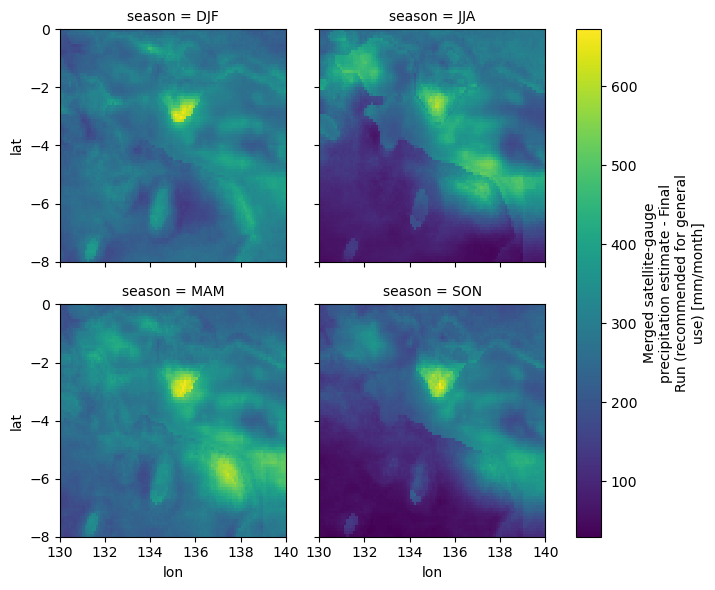

In [70]:
# Grouping data hujan berdasarkan musim. 
# Fungsi 'groupby' dengan 'time.season' akan otomatis mengelompokkan data berdasarkan musim (DJF, MAM, JJA, SON).
# DJF adalah Desember, Januari, Februari, dan seterusnya, mewakili keempat musim.
hujan_musim = hujan.groupby('time.season').mean(dim='time')  # Menghitung rata-rata untuk setiap musim.

# Membuat plot dari data hujan musiman yang telah dihasilkan.
# Parameter 'col' digunakan untuk membuat subplot berdasarkan kategori musim,
# dan 'col_wrap=2' berarti setiap baris pada plot hanya akan menampilkan 2 subplot.
hujan_musim.plot(col='season', col_wrap=2)
plt.show()

### Latihan 4

Tulislah kode untuk grouping berdasarkan tahun, dan plot dengan multipanel

In [ ]:
# Langkah 1: Grouping data berdasarkan tahun
____ = ___.groupby('time.year').mean('time')

# Langkah 2: Buat plot dengan multi-panel, satu panel untuk setiap tahun
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))  # Sesuaikan jumlah baris dan kolom berdasarkan jumlah tahun
axs = axs.ravel()  # Ubah array 2D dari axs menjadi 1D untuk iterasi yang mudah

for i, ax in enumerate(axs):
    # Plot data suhu tahunan untuk setiap tahun pada subplot yang berbeda
    ___.isel(year=i).plot(ax=ax)
    ax.set_title(f"_____")  # Set judul untuk setiap subplot
    ax.set_ylabel('____')  # Set label sumbu y

# Atur padding antar subplot untuk kejelasan
plt.tight_layout()
plt.show()

## Masking

In [72]:
lon = gpm_data['lon']
lat = gpm_data['lat']

# Mengelompokkan data hujan berdasarkan bulan dan menyimpan grup-grup tersebut
group_bulanan = hujan.groupby('time.month').groups
jan = group_bulanan[1] # Mengakses grup data untuk bulan Januari (bulan ke-1)

# Menggunakan indeks dari grup Januari untuk memilih data pada waktu tersebut dan menghitung rata-rata bulanan
hujan_jan = hujan.isel(time=jan).mean(dim='time')
# Membuat mask pada data rata-rata Januari di mana hanya nilai yang lebih besar dari 300 yang akan ditampilkan
hujan_jan_mask = hujan_jan.where(hujan_jan > 300)

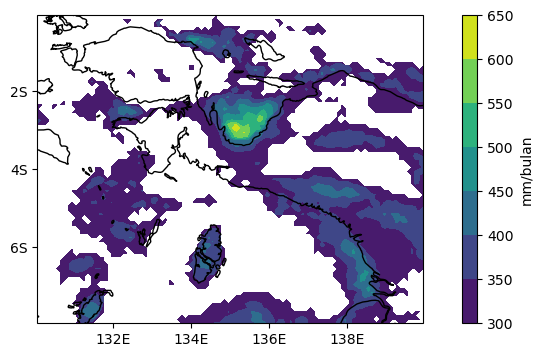

In [73]:
plt.figure(figsize =(10.,4.))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([132, 134, 136, 138, 140],crs=datacrs)
ax.set_yticks([0, -2, -4, -6, -8], crs=datacrs)
lon_formatter = LongitudeFormatter(number_format='.0f',
                                       degree_symbol='',
                                       dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='.0f',
                                      degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines()

plot_hujan = ax.contourf(lon, lat, hujan_jan_mask, transform=ccrs.PlateCarree())
plt.colorbar(plot_hujan, label='mm/bulan')
plt.show()

## Plot Hovmoller

In [124]:
hujan_lon135 = hujan.sel(lon=slice(134,136)).mean(dim='lon')
time = gpm_data['time']

(137, 80)

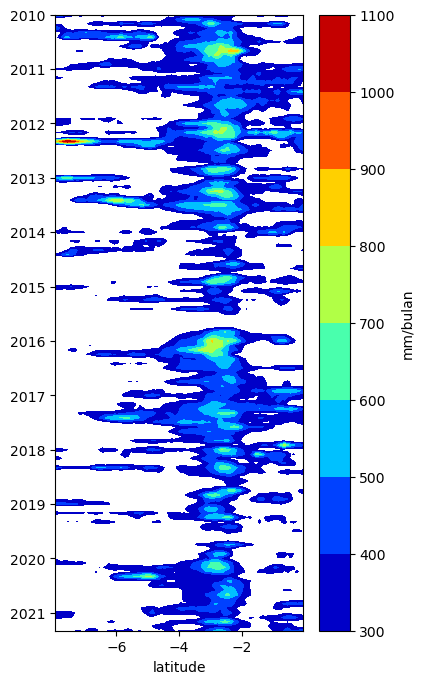

In [141]:
# Define levels for contouring
levels = np.arange(300, 1200, 100)

cmap = plt.get_cmap('jet')
cmap.set_under('white')

import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(4, 8))
ax.yaxis.set_major_locator(mdates.YearLocator())
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plot_hov = ax.contourf(lat, time, hujan_lon135, levels=levels, cmap=cmap, vmin=300)
cbar = plt.colorbar(plot_hov, ax=ax)
cbar.set_label('mm/bulan')
ax.set_xlabel('latitude')
ax.invert_yaxis()
plt.show()

In [143]:
hujan_sorong = hujan.sel(lon=131, lat=-0.8, method='nearest')
df = hujan_sorong.to_dataframe(name='precipitation')
df['year'] = df.index.get_level_values('time').year
df['month'] = df.index.get_level_values('time').month

# Pivot to reshape data for heatmap
pivot_table = df.pivot_table(values='precipitation', index='year', columns='month', aggfunc=np.mean)

/var/folders/z5/bvsj1t152zg7m9tf2tr_9yth0000gn/T/ipykernel_26399/1075829636.py:6: FutureWarning: The provided callable <function mean at 0x10850c940> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_table = df.pivot_table(values='precipitation', index='year', columns='month', aggfunc=np.mean)


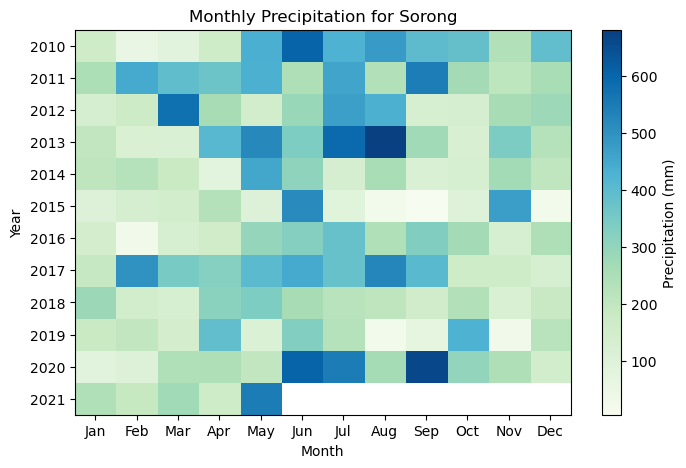

In [154]:
# Plotting the heatmap
fig, ax = plt.subplots(figsize=(8., 5.))
cax = ax.imshow(pivot_table, aspect='auto', cmap='GnBu')
cbar = fig.colorbar(cax)
cbar.set_label('Precipitation (mm)')

# Set ticks and labels
ax.set_xticks(np.arange(12))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_yticks(np.arange(len(pivot_table)))
ax.set_yticklabels(pivot_table.index)

ax.set_title('Monthly Precipitation for Sorong')
ax.set_xlabel('Month')
ax.set_ylabel('Year')

plt.show()

# Referensi / Materi lanjutan
1. Xarray (https://docs.xarray.dev/en/latest/index.html)
2. Cartopy (https://scitools.org.uk/cartopy/docs/latest/)
3. Matplotlib (https://matplotlib.org/stable/gallery/index.html)
4. Unidata Introduction to Python for Atmospheric Science & Meteorology (https://unidata.github.io/python-training/python/intro-to-python/)
5. Dask (https://examples.dask.org/xarray.html)
6. MetPy (https://unidata.github.io/MetPy/latest/)
7. Statistics for Weather and Climate Science (https://www.reading.ac.uk/meteorology/online-courses/classes/statistics-for-weather-and-climate-science)